# Classification of Red Wine
By Kevin Chen, Peidong Qin, Allison Luna, and Akshay Tripathi

### Introduction

Wine is a beverage that humans have enjoyed consuming for thousands of years, with evidence of consumption even in ancient China and Georgia, around 6000 B.C. What they consider as wine varies from place to place. Ancient China created wine using honey and fruits, while Georgia used fermented grapes which is closer to what we expect today. As time went on and with the occurrence of the agricultural evolutions, many regions around the world have come to make wine using differing techniques (Lance in Motion, 2017). One of the most common ways wine is judged is based on quality level. Quality level is defined as a measure of how good a wine is, according to experts who take into account aspects such as aging potential, subtlety, and complexity, on a scale from zero to ten (Jackson, 2008). This study explores if we can predict the quality level of various “Vinho Verde” red wines using measurements of their fixed acidity, pH, density, and citric acid level. To answer this question, we acquired a tidy dataset from Kaggle named “Wine Quality Dataset”. It includes 1597 rows, each of which represents one type of red wine. It includes 12 variables including quality level, fixed acidity, pH, density, alcohol percentage, and residual sugar amount.


### Method and Results

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

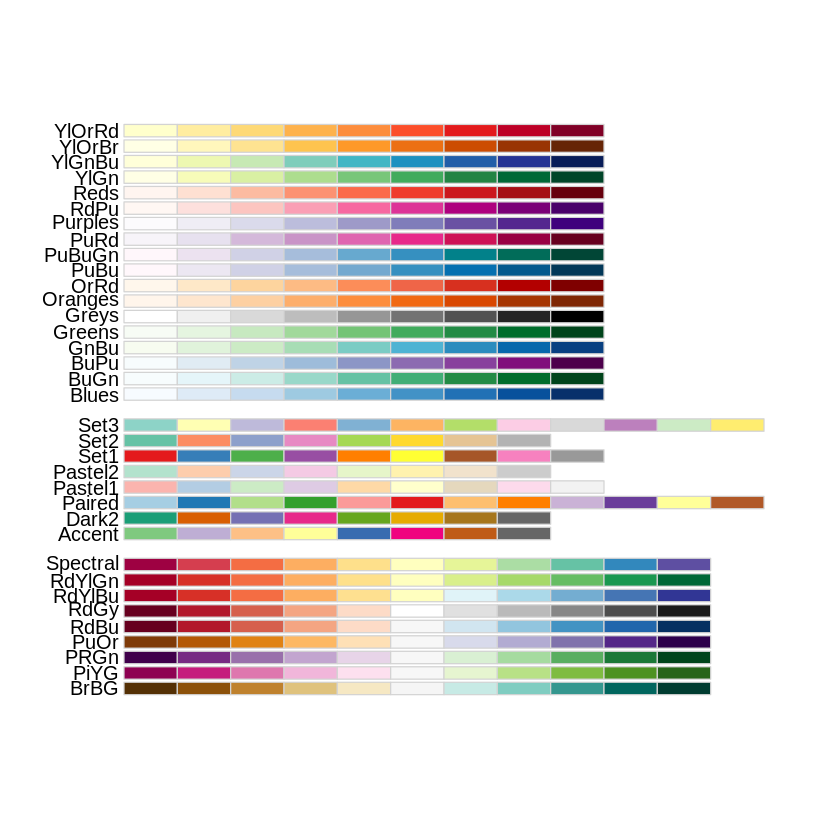

In [2]:
library(repr)
library(tidyverse)
library(tidymodels)
library(gridExtra)
library(RColorBrewer)
display.brewer.all()
palette('Dark2')

In [3]:
data <- read_csv("https://raw.githubusercontent.com/allisonml/Wine-Data/main/WineQT.csv")
names(data) <- gsub(" ", "_", colnames(data))
    
head(data)

relevant_data <- data %>%
    select(fixed_acidity, citric_acid, density, pH, quality) %>%
    mutate(quality=as_factor(quality))
    
head(relevant_data)

Parsed with column specification:
cols(
  `fixed acidity` = col_double(),
  `volatile acidity` = col_double(),
  `citric acid` = col_double(),
  `residual sugar` = col_double(),
  chlorides = col_double(),
  `free sulfur dioxide` = col_double(),
  `total sulfur dioxide` = col_double(),
  density = col_double(),
  pH = col_double(),
  sulphates = col_double(),
  alcohol = col_double(),
  quality = col_double(),
  Id = col_double()
)



fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,Id
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,0
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,1
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,2
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,3
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,4
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,5


fixed_acidity,citric_acid,density,pH,quality
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.4,0.00,0.9978,3.51,5
7.8,0.00,0.9968,3.20,5
7.8,0.04,0.9970,3.26,5
11.2,0.56,0.9980,3.16,6
7.4,0.00,0.9978,3.51,5
7.4,0.00,0.9978,3.51,5


In [4]:
set.seed(2341)
# split the data into training and testing sets
split_data <- initial_split(relevant_data, prop = 0.75, strata = quality)
training_data <- training(split_data)
testing_data <- testing(split_data)

# num of vars, if data is standardized, number of observations, and number of rows missing data in our training data
data_summary <- 
    tibble(num_variables = ncol(training_data), 
           standardized = as.factor("No"), 
           total_observations = nrow(training_data),
           rows_missing_data = 0L)

data_summary

num_variables,standardized,total_observations,rows_missing_data
<int>,<fct>,<int>,<int>
5,No,858,0


In [5]:
# mean predictor values and number of observations in each class
class_summary <- training_data %>% 
    group_by(quality) %>%
    summarize(num_observations = n(),
              mean_fixed_acidity = mean(fixed_acidity),
              mean_citric_acid = mean(citric_acid),
              mean_density = mean(density),
              mean_pH = mean(pH))

class_summary


`summarise()` ungrouping output (override with `.groups` argument)



quality,num_observations,mean_fixed_acidity,mean_citric_acid,mean_density,mean_pH
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
3,5,7.820000,0.1220000,0.9970580,3.384000
4,25,7.888000,0.1836000,0.9964876,3.377600
5,364,8.204945,0.2360440,0.9971325,3.298599
6,345,8.280870,0.2635072,0.9965700,3.323826
7,109,8.956881,0.3839450,0.9961697,3.284954
8,10,9.160000,0.4440000,0.9961860,3.219000


In [6]:
set.seed(2341)
# split the data into training and testing sets
split_data <- initial_split(relevant_data, prop = 0.75, strata = quality)
training_data <- training(split_data)
testing_data <- testing(split_data)

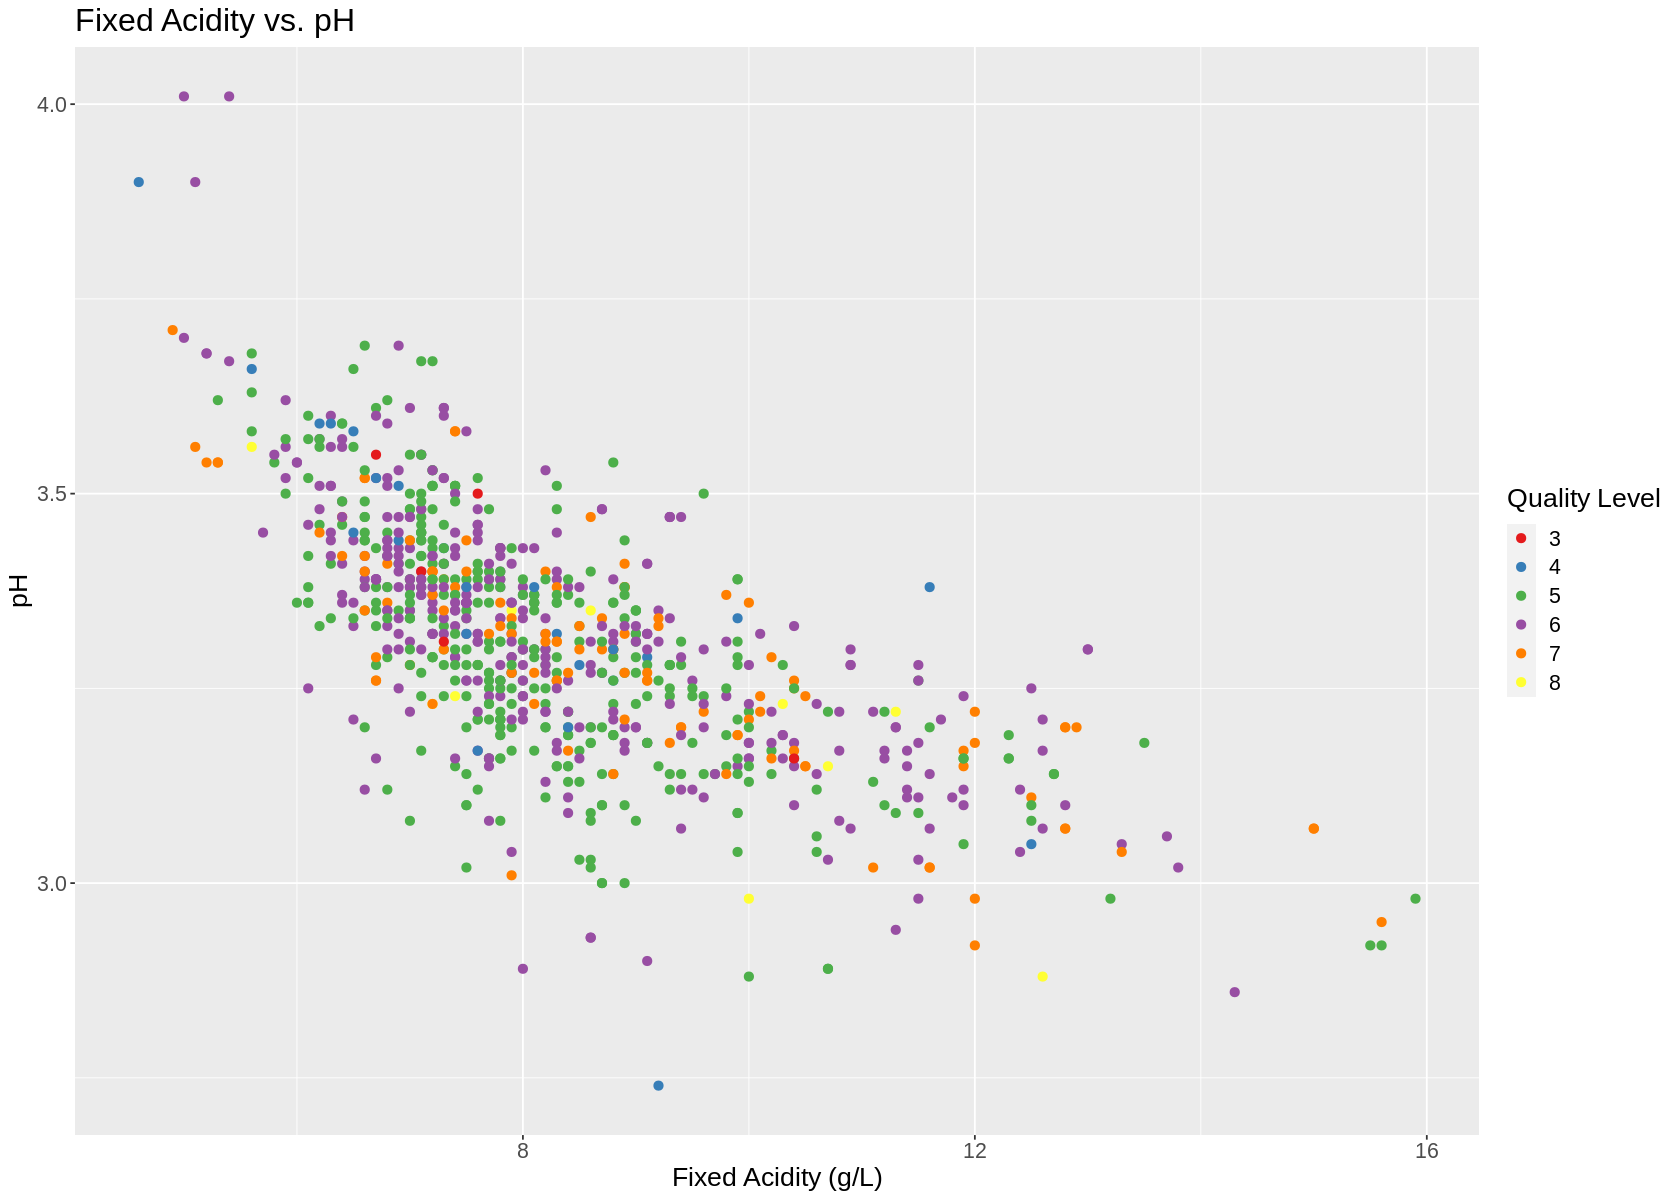

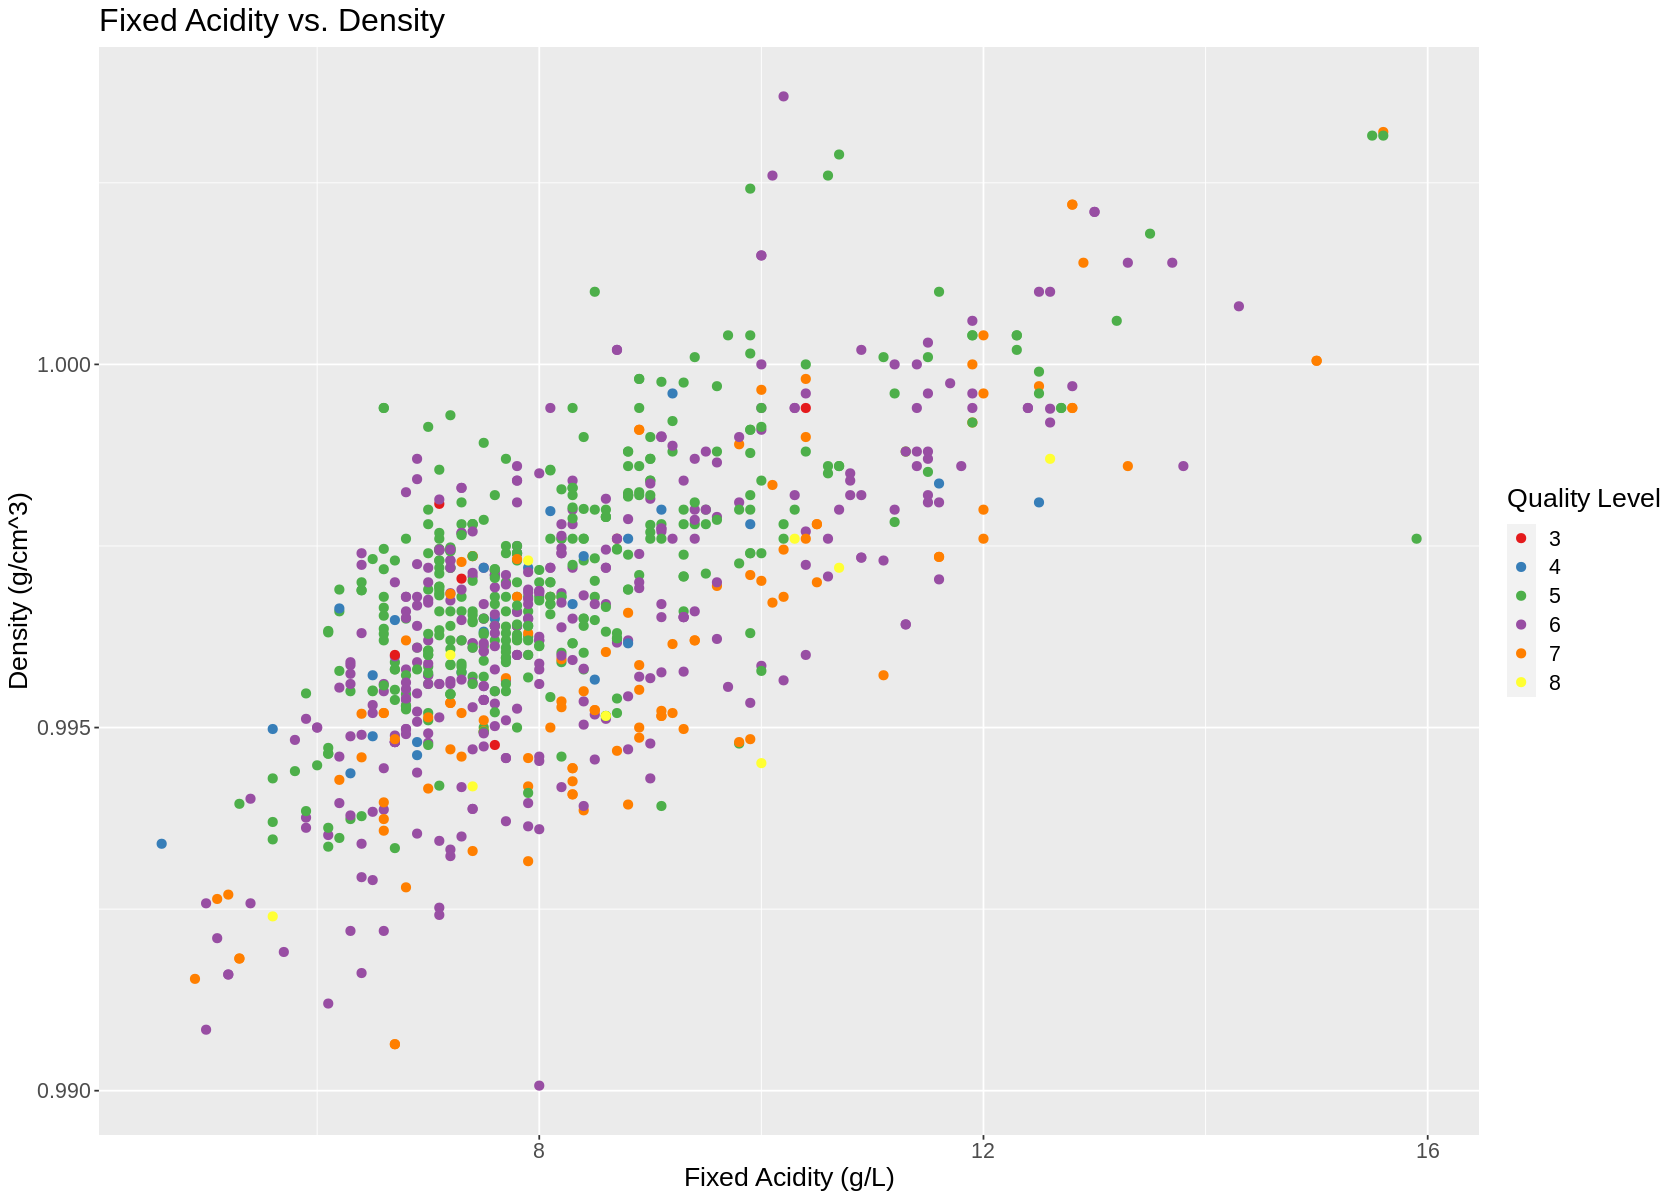

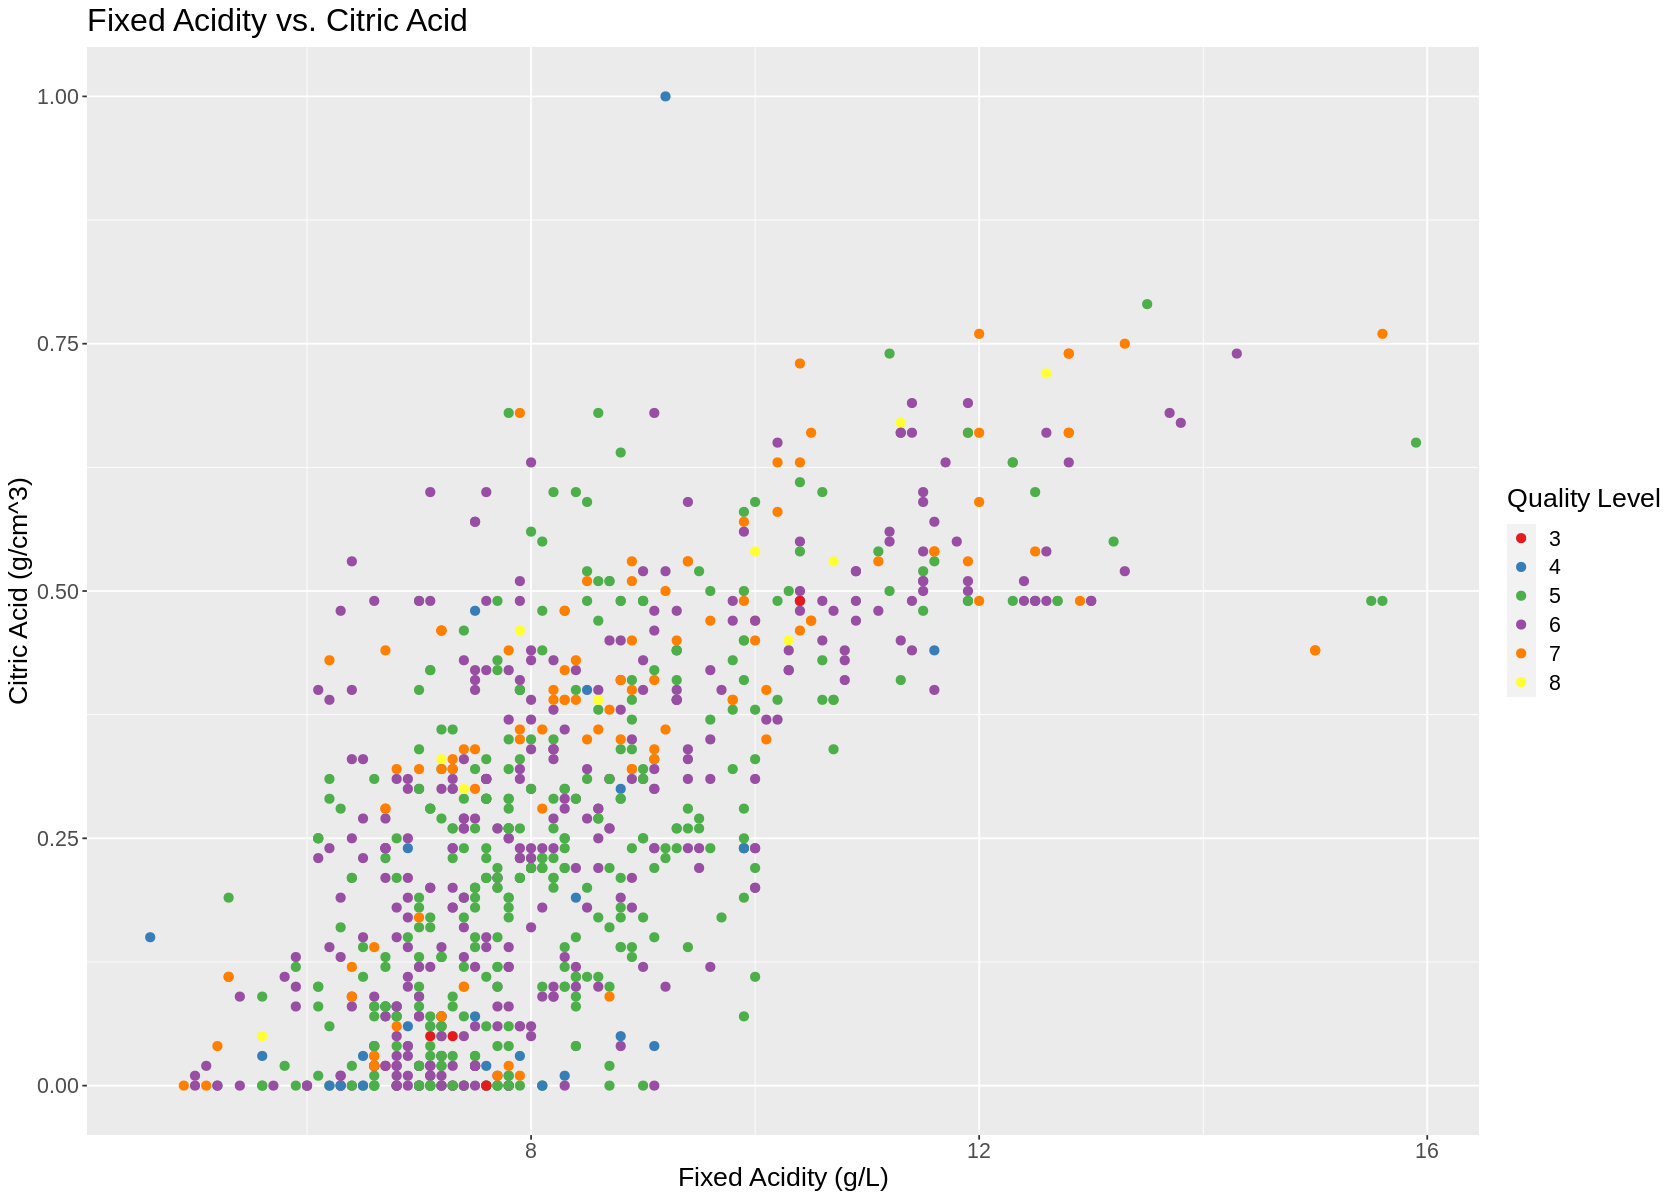

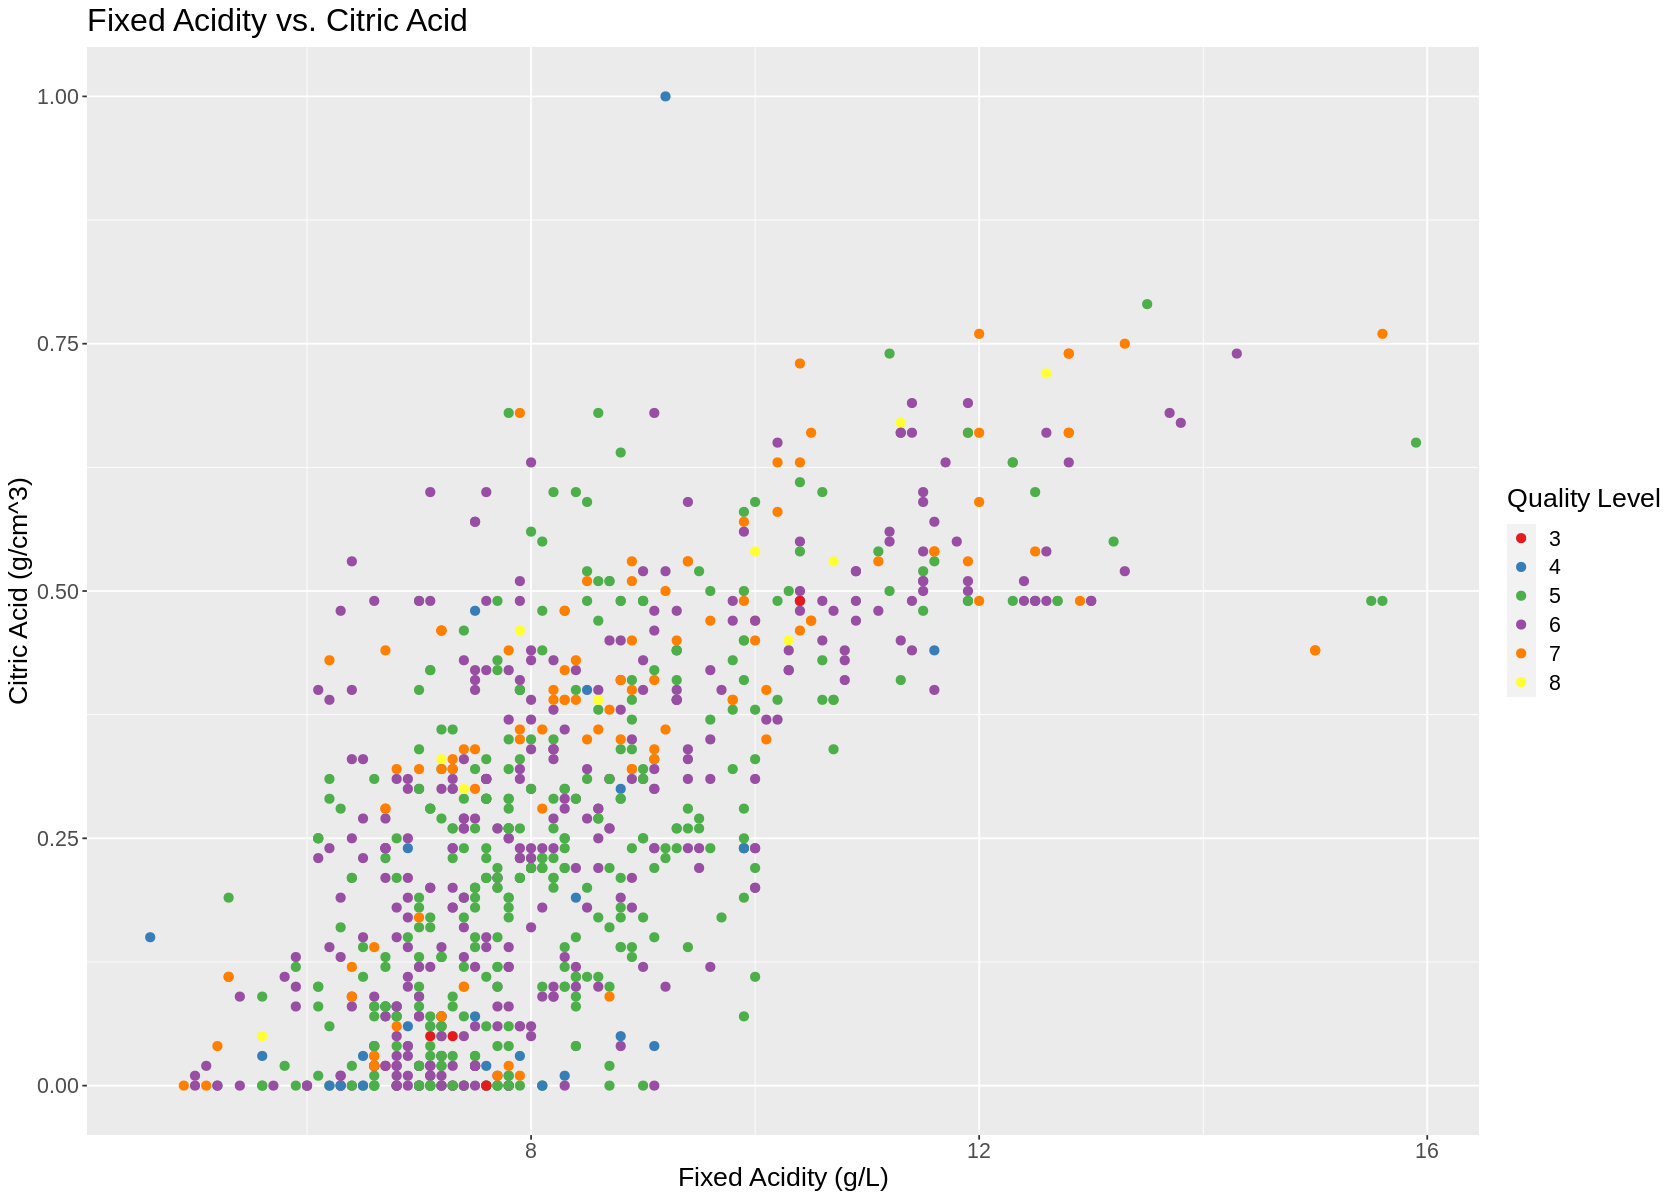

In [29]:
options(repr.plot.width=14, repr.plot.height=10)

# Fixed Acidity vs. pH
fixed_ph_plot <- training_data %>%
    ggplot(aes(x=fixed_acidity, y=pH, color=quality)) +
    geom_point(size = 2.2) +
    theme(text = element_text(size = 16)) +
    labs(x="Fixed Acidity (g/L)", y="pH", color = "Quality Level")+
    ggtitle("Fixed Acidity vs. pH")+
    scale_color_brewer(palette = "Set1")

fixed_ph_plot

# Fixed Acidity vs. Density
fixed_density_plot <- training_data %>%
    ggplot(aes(x=fixed_acidity, y=density, color=quality)) +
    geom_point(size = 2.2) +
    theme(text = element_text(size = 16)) +
    labs(x="Fixed Acidity (g/L)", y="Density (g/cm^3)", color = "Quality Level")+
    ggtitle("Fixed Acidity vs. Density")+
    scale_color_brewer(palette = "Set1")

fixed_density_plot

# Fixed Acidity vs. Citric Acid
fixed_citric_plot <- training_data %>%
    ggplot(aes(x=fixed_acidity, y=citric_acid, color=quality)) +
    geom_point(size = 2.2) +
    theme(text = element_text(size = 16)) +
    labs(x="Fixed Acidity (g/L)", y="Citric Acid (g/cm^3)", color = "Quality Level")+
    ggtitle("Fixed Acidity vs. Citric Acid")+
    scale_color_brewer(palette = "Set1")

fixed_citric_plot

# pH vs. Density
ph_density_plot <- training_data %>%
    ggplot(aes(x=pH, y=density, color=quality)) +
    geom_point(size = 2.2) +
    theme(text = element_text(size = 16)) +
    labs(x="pH", y="Density (g/cm^3)", color = "Quality Level")+
    ggtitle("pH vs. Density")+
    scale_color_brewer(palette = "Set1")

fixed_citric_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



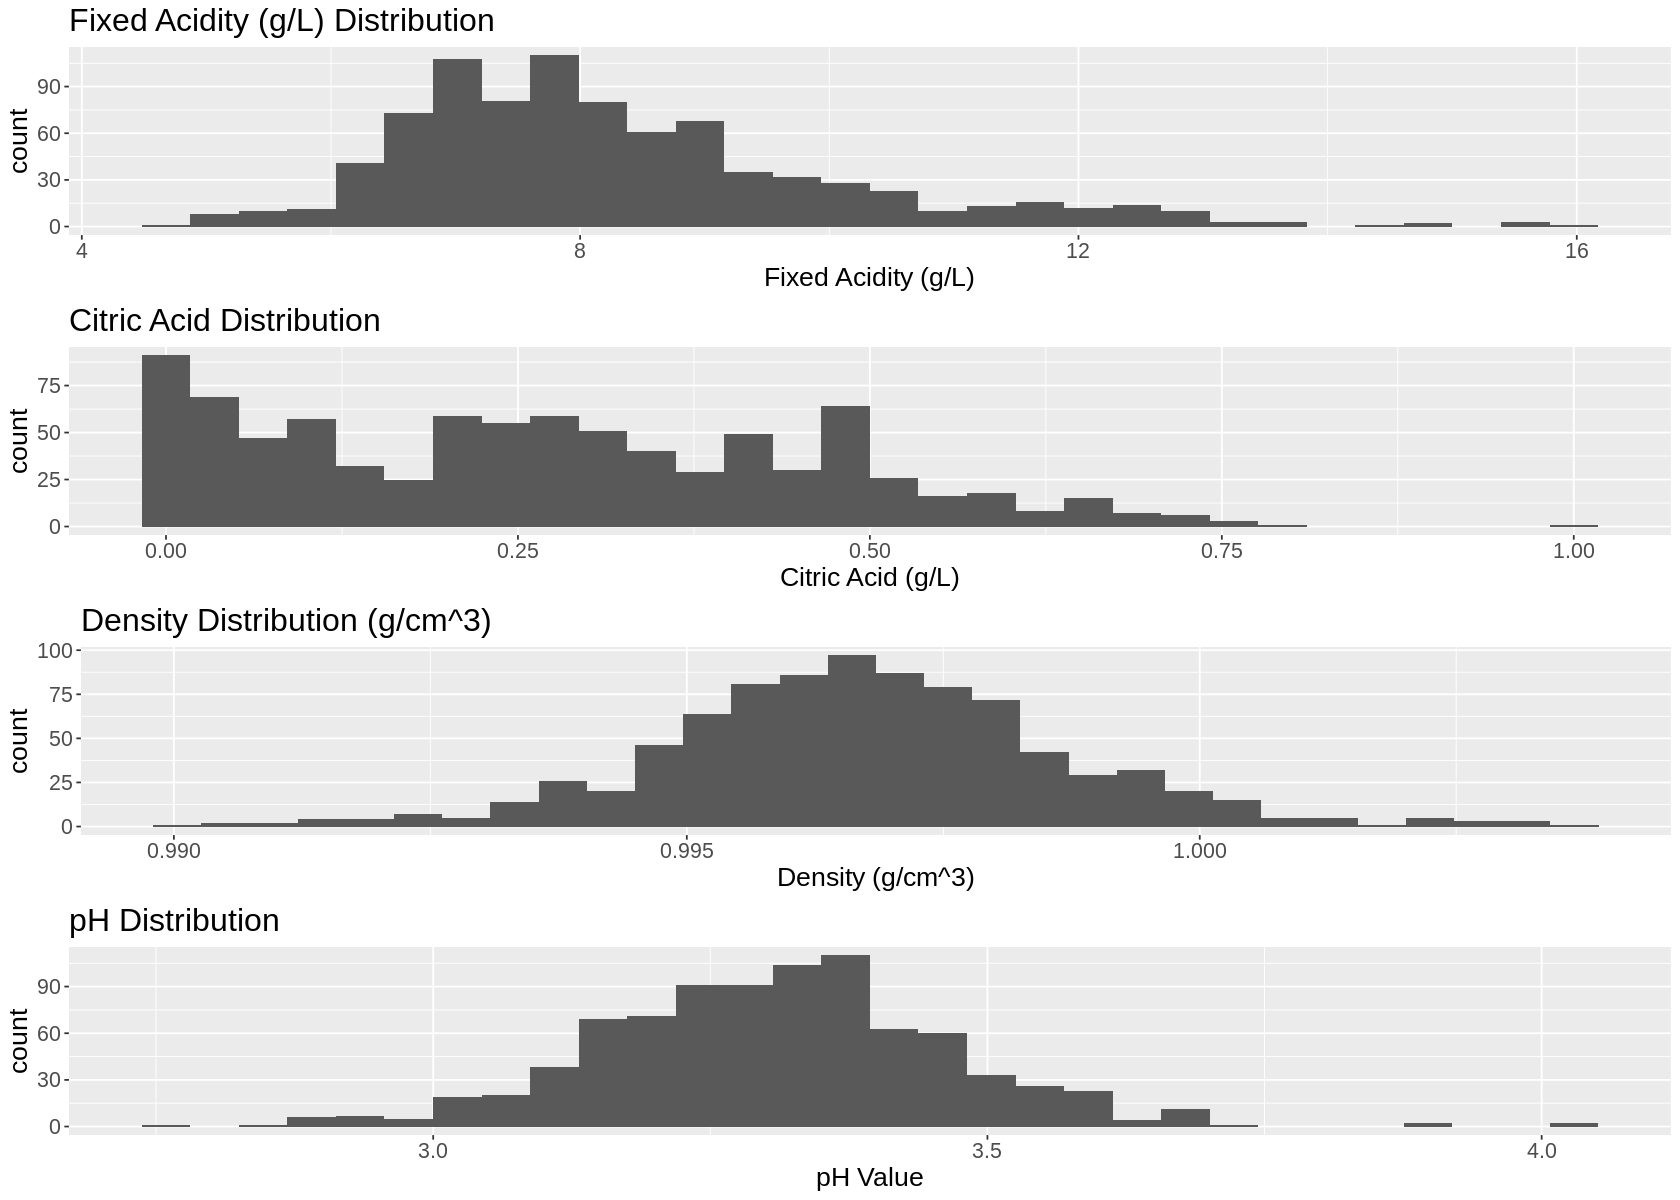

In [8]:
options(repr.plot.width=14, repr.plot.height=10)

# Alcohol Percentage Histogram
pH_hist <- training_data %>%
    ggplot(aes(x=pH)) +
    geom_histogram() +
    theme(text = element_text(size = 16)) +
    labs(x="pH Value")+
    ggtitle("pH Distribution")
# Density Histogram
density_hist <- training_data %>%
    ggplot(aes(x=density)) +
    geom_histogram() +
    theme(text = element_text(size = 16)) +
    labs(x="Density (g/cm^3)")+
    ggtitle("Density Distribution (g/cm^3)")
# Citric Acid Histogram
citric_hist <- training_data %>%
    ggplot(aes(x=citric_acid)) +
    geom_histogram() +
    theme(text = element_text(size = 16)) +
    labs(x="Citric Acid (g/L)")+
    ggtitle("Citric Acid Distribution")
# Fixed Acidity Histogram
fixed_hist <- training_data %>%
    ggplot(aes(x=fixed_acidity)) +
    geom_histogram() +
    theme(text = element_text(size = 16)) +
    labs(x="Fixed Acidity (g/L)")+
    ggtitle("Fixed Acidity (g/L) Distribution")

grid.arrange(fixed_hist, citric_hist, density_hist, pH_hist, ncol = 1)


In [9]:
set.seed(2341)
wine_recipe <- recipe(quality ~ pH + density + fixed_acidity + citric_acid , data = training_data) %>%
    step_scale(all_predictors()) %>%
    step_scale(all_predictors())
wine_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Scaling for all_predictors()

In [10]:
set.seed(2341)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
       set_engine("kknn") %>%
       set_mode("classification")
knn_spec

knn_fit <- workflow() %>%
       add_recipe(wine_recipe) %>%
       add_model(knn_spec) %>%
       fit(data = training_data)

knn_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 3
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~3, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.5128205
Best kernel: rectangular
Best k: 3

In [11]:
set.seed(2341) # DO NOT REMOVE

wine_test_predictions <- predict(knn_fit , testing_data) %>%
       bind_cols(testing_data)


wine_test_predictions

.pred_class,fixed_acidity,citric_acid,density,pH,quality
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,7.9,0.06,0.9964,3.30,5
5,8.5,0.56,0.9969,3.30,7
5,8.3,0.12,0.9966,3.17,5
5,5.2,0.25,0.9957,3.38,5
5,7.5,0.20,0.9968,3.21,6
5,8.8,0.26,0.9971,3.15,5
6,8.6,0.36,0.9970,3.20,5
6,10.2,0.57,0.9971,3.04,5
6,8.8,0.40,0.9980,3.44,5


In [12]:
set.seed(2341) # DO NOT REMOVE

wine_prediction_accuracy <- wine_test_predictions %>%
        metrics(truth = quality, estimate = .pred_class) %>%
        filter(.metric == "accuracy")

wine_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4912281


In [13]:
set.seed(2341) # DO NOT REMOVE

wine_mat <- wine_test_predictions %>% 
       conf_mat(truth = quality, estimate = .pred_class)

" Quality is best at quality =8 , and it average at quality = 5 , and its a poor quality wine when quality = 3"
wine_mat

[1] " Quality is best at quality =8 , and it average at quality = 5 , and its a poor quality wine when quality = 3"

          Truth
Prediction  3  4  5  6  7  8
         3  0  0  0  0  0  0
         4  0  0  1  4  0  0
         5  0  6 71 49  7  0
         6  1  2 38 52  7  2
         7  0  0  8 11 17  4
         8  0  0  1  1  3  0

In [14]:
set.seed(2341) # DO NOT REMOVE

wine_vfold <- vfold_cv(training_data, v = 10, strata = quality)



In [15]:
set.seed(2341) # DO NOT REMOVE

wine_resample_fit <- workflow() %>%
       add_recipe(wine_recipe) %>%
       add_model(knn_spec) %>%
       fit_resamples(resamples = wine_vfold)


! Fold02: internal: No observations were detected in `truth` for level(s): '3', '8...

! Fold03: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold04: internal: No observations were detected in `truth` for level(s): '8'
Com...

! Fold05: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold06: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold08: internal: No observations were detected in `truth` for level(s): '3', '8...



In [16]:
wine_metrics <- wine_resample_fit %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")
wine_metrics

accuracy <- wine_metrics %>%
    select(mean) %>%
    pull(1)

accuracy

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,multiclass,0.4952682,10,0.01183203


[1] 0.4952682

In [17]:
set.seed(2341) # DO NOT REMOVE
knn_tune <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [18]:
set.seed(1234) # set the seed, don't remove this

knn_results <- workflow() %>%
       add_recipe(wine_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = wine_vfold, grid = 10) %>%
       collect_metrics()


knn_results

! Fold02: internal: No observations were detected in `truth` for level(s): '3', '8...

! Fold03: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold04: internal: No observations were detected in `truth` for level(s): '8'
Com...

! Fold05: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold06: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold08: internal: No observations were detected in `truth` for level(s): '3', '8...



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.5070348,10,0.010266104,Model01
2,roc_auc,hand_till,0.5810266,10,0.010376029,Model01
3,accuracy,multiclass,0.4952682,10,0.011832026,Model02
3,roc_auc,hand_till,0.5802313,10,0.009828473,Model02
4,accuracy,multiclass,0.4860588,10,0.009608555,Model03
4,roc_auc,hand_till,0.5790089,10,0.012090629,Model03
5,accuracy,multiclass,0.4802022,10,0.012370327,Model04
5,roc_auc,hand_till,0.5778196,10,0.011097332,Model04
7,accuracy,multiclass,0.4745890,10,0.010663444,Model05


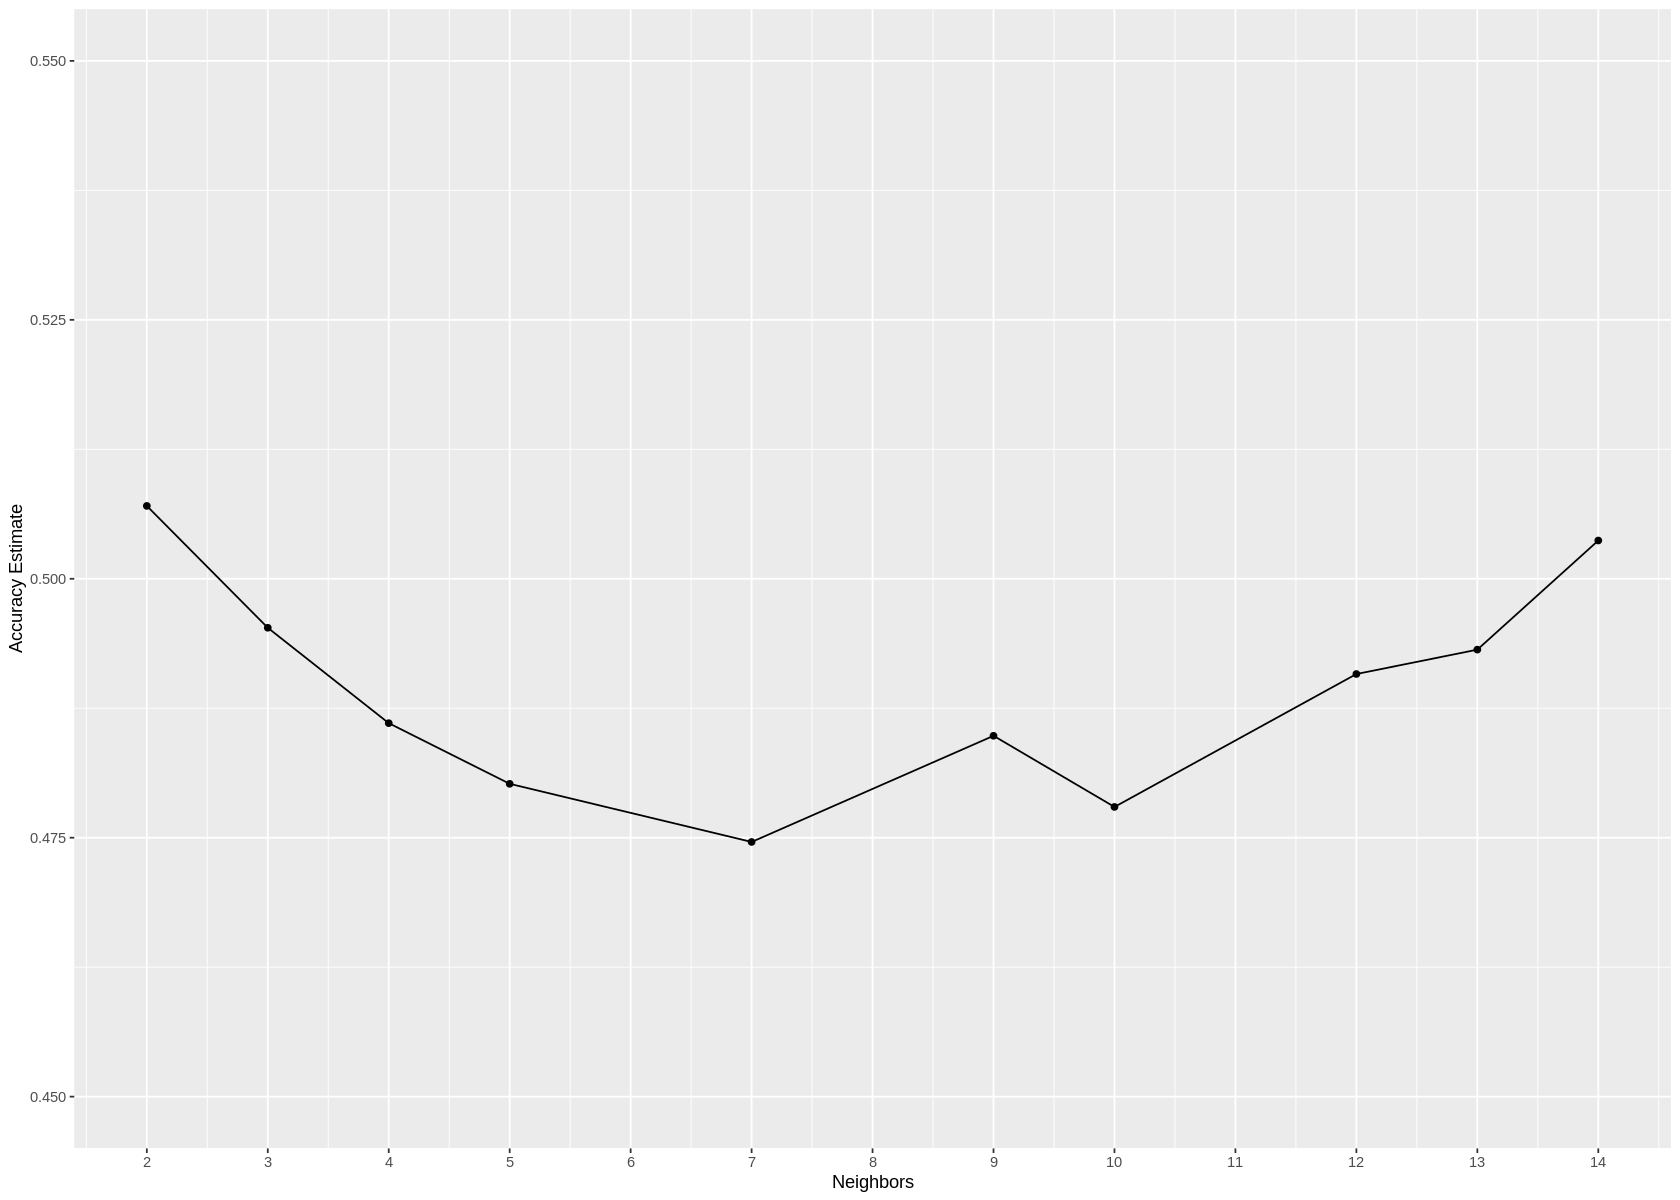

In [19]:
accuracies <- knn_results %>% 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 20, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.45, 0.55)) # adjusting the y-axis


accuracy_versus_k

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 2
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~3, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.5128205
Best kernel: rectangular
Best k: 3

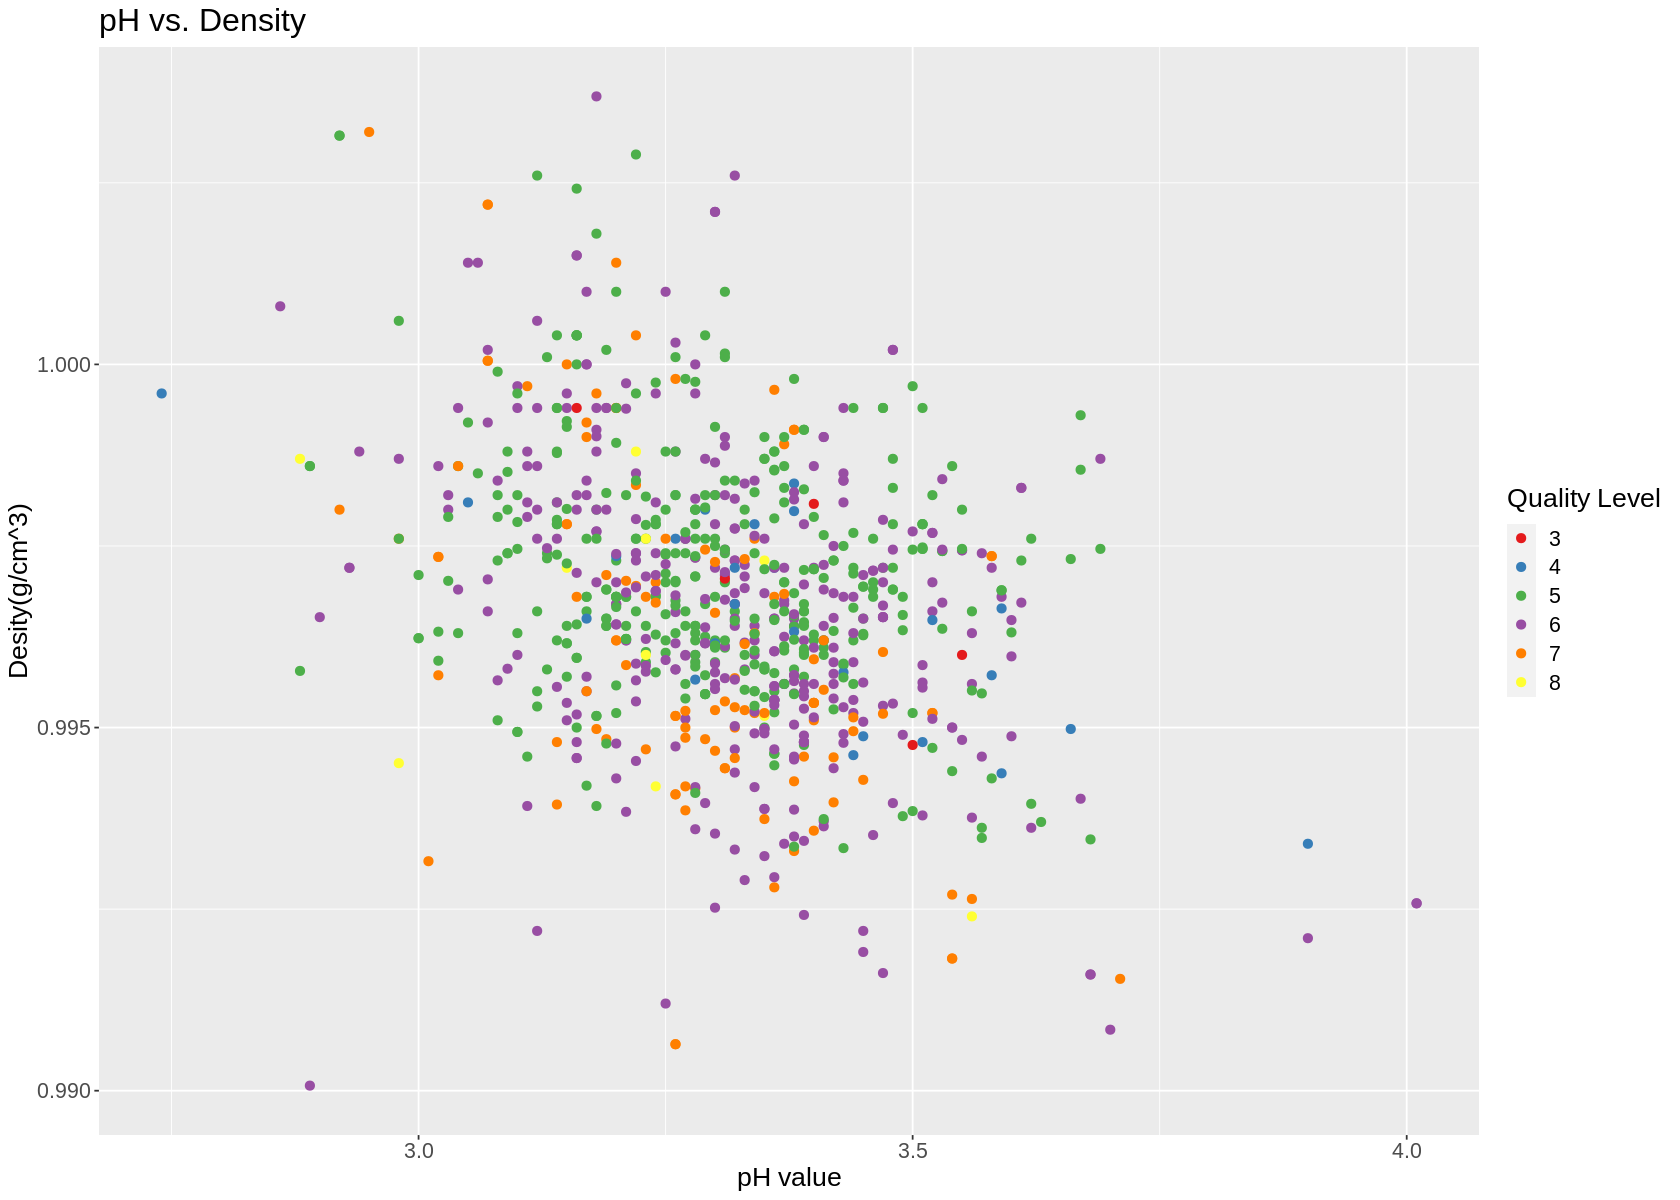

In [20]:
set.seed(2341)

wine_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) %>%
       set_engine("kknn") %>%
       set_mode("classification")
wine_spec

wine_fit <- workflow() %>%
       add_recipe(wine_recipe) %>%
       add_model(knn_spec) %>%
       fit(data = training_data)

wine_fit

pH_density_plot <- training_data %>%
    ggplot(aes(x=pH, y=density, color=quality)) +
    geom_point(size = 2.2) +
    theme(text = element_text(size = 16)) +
    labs(x="pH value", y="Desity(g/cm^3)", color = "Quality Level")+
    ggtitle("pH vs. Density")+
    scale_color_brewer(palette = "Set1")
pH_density_plot

In [21]:
# mean and sd for all predictor variables (not divided by class)
predictor_summary <- training_data %>%
    select(fixed_acidity:pH) %>%
    gather("predictor", "values") %>%
    group_by(predictor) %>%
    summarize(mean = mean(values), sd = sd(values))

predictor_summary

`summarise()` ungrouping output (override with `.groups` argument)



predictor,mean,sd
<chr>,<dbl>,<dbl>
citric_acid,0.2661072,0.195212233
density,0.9967537,0.001958048
fixed_acidity,8.3306527,1.770002813
pH,3.3088811,0.157801871


### Method

We plan to use alcohol percentage, along with the amounts of residual sugar, fixed acidity, and citric acid, as our predictive variables in order to classify the various red wines by their quality level. We will use k-nearest neighbours classification, separating the data into training and testing sets to create a model and cross-validate in order to check its accuracy. To visualize the results, we will colour-code scatterplots of the data against the various predictor variables and use background colour to indicate the divisions our model creates between the classes, to see how much the chosen variables associate with the quality of the wine and how well the model fits our data.


### Expected Outcome and Significance

With our limited knowledge of wine, we don't know if the factors we have at our disposal will be useful in classifying the quality of wine, or whether other factors may be better suited to the task, if they exist. There exist many different studies using various factors to predict wine quality, which all come to various conclusions of which factors best predict quality. This could be an impactful finding in the wine field since the quality of a wine will dramatically affect its price point. In finding which factors affect the quality of wine, winemaking industries can use this information to potentially produce higher quality wines more purposefully. Since we have limited time and ability, our research has been limited to 4 variables within a single dataset, but future research can include more variables from different datasets to attempt to determine a more accurate model and conclusion as to what affects the quality of red wine. Additionally, future studies can explore if these factors associate with the quality of other types of wine in a similar way.